# 3. Scattering transformation

If you made up to here, it likely means that you have successfully designed a scattering network for seismic data using ScatSeisNet. In this notebook, we will apply the scattering transformation to the seismograms and visualize the resulting scattering coefficients. This process involves convolving the input signal with the wavelets defined in the scattering network and computing the modulus and pooling operations to obtain the scattering coefficients.

In [101]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
from obspy import read

In [102]:
%config InlineBackend.figure_format = "svg"

## Load scattering network and seismograms

First, we need to load the scattering network that we designed in the previous tutorial. We will also load the seismogram data that contains the tremor signals that we introduced at the beginning of this tutorial series.

In [103]:
network = pickle.load(open("../example/scattering_network.pickle", "rb"))
stream = read("../example/stream.mseed")

## Create seismogram segments

Before applying the scattering network, we need to divide our continuous seismogram into segments of equal length. The segment duration was defined when we created the scattering network in the previous notebook, so we can extract that information directly from the network object. We use overlapping windows to avoid losing information at segment boundaries, with 50% overlap between consecutive segments.

In [104]:
segment_duration_seconds = network.bins / network.sampling_rate
segment_overlap_seconds = segment_duration_seconds / 2

# Collect segments and timestamps (window start time)
segments = list()
timestamps = list()
for segment in stream.slide(segment_duration_seconds, segment_overlap_seconds):
    timestamps.append(segment[0].stats.starttime.datetime)
    segments.append(np.array([tr.data[: network.bins] for tr in segment]))

# Log
print(
    f"Extracted {len(segments)} segments "
    f"from {timestamps[0]} to {timestamps[-1]}"
)

Extracted 4319 segments from 2015-12-04 00:00:00 to 2015-12-04 23:59:20


## Apply the scattering transformation

Now we can calculate the scattering coefficients from our data segments. The network processes each segment through its filter banks and applies a pooling operation to summarize the wavelet coefficients. 

We use median pooling here, but you could also choose maximum pooling or average pooling by changing the `reduce_type` argument. This computation might take a minute or two depending on your data size.

In [105]:
coefficients = network.transform(segments, reduce_type=np.median)

print(f"Scattering transformation complete.")
print(f"First-order coefficients shape:")
print(f"  Segments: {coefficients[0].shape[0]}")
print(f"  Channels: {coefficients[0].shape[1]}")
print(f"  Coefficients: {coefficients[0].shape[2]}")
print("Second-order coefficients shape:")
print(f"  Segments: {coefficients[1].shape[0]}")
print(f"  Channels: {coefficients[1].shape[1]}")
print(f"  Coefficients: {np.prod(coefficients[1].shape[2:])}")

Scattering transformation complete.
First-order coefficients shape:
  Segments: 4319
  Channels: 3
  Coefficients: 24
Second-order coefficients shape:
  Segments: 4319
  Channels: 3
  Coefficients: 144


## Visualize coefficients

Let's examine the first-order scattering coefficients, which resemble a classical spectrogram showing amplitude as a function of time and frequency. In our data, we can clearly see the signature of the tremor signals starting around 10:00 AM, with increasing amplitude throughout the day.

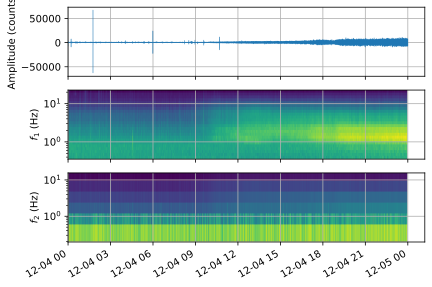

In [106]:
# Extract first-order coefficients for first channel
channel = 0

# Get trace
trace = stream[channel]

# Get scattering coefficients
center_frequencies_1 = network.banks[0].centers
center_frequencies_2 = network.banks[1].centers
order_2_f1 = 1
order_2_f1_index = np.argmin(center_frequencies_1 - order_2_f1)
order_1 = np.log10(coefficients[0][:, channel, :].squeeze())
order_2 = np.log10(coefficients[1][:, channel, order_2_f1_index].squeeze())


# Create figure and axes
fig, ax = plt.subplots(3, sharex=True, dpi=300)

# Plot the waveform
ax[0].plot(trace.times("matplotlib"), trace.data, rasterized=True, lw=0.5)
ax[0].grid()

# First-order scattering coefficients
ax[1].pcolormesh(timestamps, center_frequencies_1, order_1.T, rasterized=True)
ax[1].grid()

# Second-order scattering coefficients
ax[2].pcolormesh(timestamps, center_frequencies_2, order_2.T, rasterized=True)
ax[2].grid()

# Axes labels
ax[1].set_yscale("log")
ax[2].set_yscale("log")
ax[0].set_ylabel("Amplitude (counts)")
ax[1].set_ylabel("$f_1$ (Hz)")
ax[2].set_ylabel("$f_2$ (Hz)")
fig.autofmt_xdate()

## Save the scattering coefficients

Now that we've computed the scattering coefficients, we'll save them for use in the next tutorials where we'll explore dimensionality reduction and clustering. We save both the first and second-order coefficients along with the timestamps in a compressed NumPy file.

In [107]:
np.savez(
    "../example/scattering_coefficients.npz",
    order_1=coefficients[0],
    order_2=coefficients[1],
    times=timestamps,
)